In [ ]:
!pip install highway-env gymnasium stable-baselines3 matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
save_path = "/content/drive/MyDrive/Colab Notebooks/HIGHWAY_V1"
os.makedirs(save_path, exist_ok=True)

In [ ]:
# Create the HighwayEnvV1 class file
#%%writefile "{save_path}/highway_env_v1.py"
from __future__ import annotations
from typing import Dict, Text
import numpy as np
from highway_env import utils
from highway_env.envs.common.abstract import AbstractEnv
from highway_env.envs.common.action import Action
from highway_env.road.road import Road, RoadNetwork
from highway_env.utils import near_split
from highway_env.vehicle.controller import ControlledVehicle
from highway_env.vehicle.kinematics import Vehicle


Observation = np.ndarray


class HighwayEnvV1(AbstractEnv):
    """
    This is a re-implementation of the highway driving environment,
    which fixes the issue of non-forward moving ego-vehicles.

    The vehicle is driving on a straight highway with several lanes, and is rewarded for reaching a high speed,
    staying on the rightmost lanes and avoiding collisions.

    !! If the vehicle's accumulated heading is out of [-0.5*pi, 0.5*pi], the episode terminates.
    Also add a negative reward for large heading angle.
    """

    @classmethod
    def default_config(cls) -> dict:
        config = super().default_config()
        config.update(
            {
                "observation": {"type": "Kinematics"},
                "action": {
                    "type": "DiscreteMetaAction",
                },
                "lanes_count": 4,
                "vehicles_count": 50,
                "controlled_vehicles": 1,
                "initial_lane_id": None,
                "duration": 40,  # [s]
                "ego_spacing": 2,
                "vehicles_density": 1,
                "collision_reward": -1,  # The reward received when colliding with a vehicle.
                "right_lane_reward": 0.1,
                # The reward received when driving on the right-most lanes, linearly mapped to
                # zero for other lanes.
                "high_speed_reward": 0.4,  # The reward received when driving at full speed, linearly mapped to zero for
                # lower speeds according to config["reward_speed_range"].
                "lane_change_reward": 0,  # The reward received at each lane change action.
                "reward_speed_range": [0, 30],
                "stopping_penalty": -2,
                "reverse_reward": -1,  # The reward received when moving backward
                "normalize_reward": True,
                "offroad_terminal": False,
            }
        )
        return config

    def __init__(self, config: dict = None, render_mode: str | None = None) -> None:
        # Initialize parent class with render_mode
        super().__init__(config=config)

        # Store the render mode
        self.render_mode = render_mode

        # Delay initialization
        self._delay = 0.0
        self._delayed_frequencies = 0

    # time elapse
    def elapse(self, delay, reset_steering=False):
        self._delay = delay
        # a steering reset option may be used by the controller
        if reset_steering:
            self.unwrapped.vehicle.action["steering"] = 0
        self._delayed_frequencies = int(self._delay * self.unwrapped.config["simulation_frequency"])
        for _ in range(self._delayed_frequencies):
            self.unwrapped.road.act()
            self.unwrapped.road.step(1 / self.unwrapped.config["simulation_frequency"])

    def _reset(self) -> None:
        self._create_road()
        self._create_vehicles()

    def _create_road(self) -> None:
        """Create a road composed of straight adjacent lanes."""
        self.road = Road(
            network=RoadNetwork.straight_road_network(
                self.config["lanes_count"], speed_limit=30
            ),
            np_random=self.np_random,
            record_history=self.config["show_trajectories"],
        )

    def render(self) -> np.ndarray | None:
        if self.render_mode == "rgb_array":
            return super().render()
        else:
            super().render()

    def _create_vehicles(self) -> None:
        """Create some new random vehicles of a given type, and add them on the road."""
        other_vehicles_type = utils.class_from_path(self.config["other_vehicles_type"])
        other_per_controlled = near_split(
            self.config["vehicles_count"], num_bins=self.config["controlled_vehicles"]
        )

        self.controlled_vehicles = []
        for others in other_per_controlled:
            vehicle = Vehicle.create_random(
                self.road,
                speed=25,
                lane_id=self.config["initial_lane_id"],
                spacing=self.config["ego_spacing"],
            )
            vehicle = self.action_type.vehicle_class(
                self.road, vehicle.position, vehicle.heading, vehicle.speed
            )
            self.controlled_vehicles.append(vehicle)
            self.road.vehicles.append(vehicle)

            for _ in range(others):
                vehicle = other_vehicles_type.create_random(
                    self.road, spacing=1 / self.config["vehicles_density"]
                )
                vehicle.randomize_behavior()
                self.road.vehicles.append(vehicle)

    def _reward(self, action: Action) -> float:
        """
        The reward is defined to foster driving at high speed, on the rightmost lanes, and to avoid collisions.
        :param action: the last action performed
        :return: the corresponding reward
        """

        rewards = self._rewards(action)
        reward = sum(
            self.config.get(name, 0) * reward for name, reward in rewards.items()
        )
        if self.config["normalize_reward"]:
            reward = utils.lmap(
                reward,
                [
                    self.config["collision_reward"],
                    self.config["high_speed_reward"] + self.config["right_lane_reward"],
                ],
                [0, 1],
            )

        reward *= rewards["on_road_reward"]

        return reward

    def _rewards(self, action: Action) -> Dict[Text, float]:
        neighbours = self.road.network.all_side_lanes(self.vehicle.lane_index)
        lane = (
            self.vehicle.target_lane_index[2]
            if isinstance(self.vehicle, ControlledVehicle)
            else self.vehicle.lane_index[2]
        )

        # Use forward speed rather than speed, see https://github.com/eleurent/highway-env/issues/268
        forward_speed = self.vehicle.speed * np.cos(self.vehicle.heading)

        scaled_speed = utils.lmap(
            forward_speed, self.config["reward_speed_range"], [0, 1]
        )

        reverse_reward = np.abs(self.vehicle.heading)
        reverse_reward = utils.lmap(reverse_reward, [0.25 * np.pi, 0.5 * np.pi], [0, 1])

        # (for convenience) if reversed, the vehicle is considered "crashed"
        if not (-0.5 * np.pi < self.vehicle.heading < 0.5 * np.pi) or forward_speed <= 0:
            self.vehicle.crashed = True

        stopping_penalty = -0.5 if forward_speed < 2 else 0

        return {
            "collision_reward": float(self.vehicle.crashed),
            "right_lane_reward": lane / max(len(neighbours) - 1, 1),
            "high_speed_reward": np.clip(scaled_speed, 0, 1),
            "on_road_reward": float(self.vehicle.on_road),
            "reverse_reward": np.clip(reverse_reward, 0, 1),
            "stopping_penalty": stopping_penalty
        }

    def _is_terminated(self) -> bool:
        """The episode is over if the ego vehicle crashed."""
        return self.vehicle.crashed or (
            self.config["offroad_terminal"] and not self.vehicle.on_road
        )

    def _is_truncated(self) -> bool:
        """The episode is truncated if the time limit is reached."""
        return self.time >= self.config["duration"]



In [ ]:
# Register the custom environment with Gymnasium
#%%writefile "{save_path}/register_env.py"
from gymnasium.envs.registration import register
import highway_env

# Register the custom environment
register(
    id='highway-v1',
    entry_point='highway_env_v1:HighwayEnvV1',
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
# Add the environment path to Python's system path
import sys
env_path = '/content/drive/MyDrive/Colab Notebooks/HIGHWAY_V1'
if env_path not in sys.path:
    sys.path.append(env_path)

# Import the registration code
import register_env

# Now you can create and use the environment
import gymnasium as gym

# Create the environment
env = gym.make('highway-v1', render_mode='rgb_array')
env.unwrapped.configure({
    "action": {"type": "ContinuousAction"}
})

# Reset the environment
obs, info = env.reset()

In [ ]:
from stable_baselines3 import DDPG
from stable_baselines3.common.env_checker import check_env

# Verify the environment compatibility with Stable-Baselines3
print("Checking environment compatibility...")
check_env(env, warn=True)

# Load the saved model
model = DDPG.load("/content/drive/MyDrive/Colab Notebooks/HIGHWAY_V1/DDPG/ddpg_highwayv1.zip", env=env)

Checking environment compatibility...


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.set_env(env)
model.learn(total_timesteps=10000, tb_log_name="ddpg1",reset_num_timesteps=False)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ddpg_highway_tensorboard/ddpg1_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.2     |
|    ep_rew_mean     | 20.4     |
| time/              |          |
|    episodes        | 1788     |
|    fps             | 2        |
|    time_elapsed    | 20       |
|    total_timesteps | 45053    |
| train/             |          |
|    actor_loss      | -91      |
|    critic_loss     | 0.466    |
|    learning_rate   | 0.0003   |
|    n_updates       | 44952    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.3     |
|    ep_rew_mean     | 20.3     |
| time/              |          |
|    episodes        | 1792     |
|    fps             | 2        |
|    time_elapsed    | 53       |
|    total_timesteps | 45133    |
| train/             |          |
|    actor_loss      | -88.7 

/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = utils.lmap(df[feature], [f_range[0], f_range[1]], [-1, 1])


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.9     |
|    ep_rew_mean     | 20       |
| time/              |          |
|    episodes        | 1824     |
|    fps             | 2        |
|    time_elapsed    | 479      |
|    total_timesteps | 46221    |
| train/             |          |
|    actor_loss      | -90.8    |
|    critic_loss     | 2.14     |
|    learning_rate   | 0.0003   |
|    n_updates       | 46120    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.5     |
|    ep_rew_mean     | 19.7     |
| time/              |          |
|    episodes        | 1828     |
|    fps             | 2        |
|    time_elapsed    | 518      |
|    total_timesteps | 46317    |
| train/             |          |
|    actor_loss      | -91.9    |
|    critic_loss     | 1.96     |
|    learning_rate   | 0.0003   |
|    n_updates       | 46216    |
--------------

In [ ]:
model.learn(total_timesteps=10000, tb_log_name="ddpg1",reset_num_timesteps=False)

Logging to ddpg_highway_tensorboard/ddpg1_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31       |
|    ep_rew_mean     | 18.7     |
| time/              |          |
|    episodes        | 2096     |
|    fps             | 2        |
|    time_elapsed    | 21       |
|    total_timesteps | 55050    |
| train/             |          |
|    actor_loss      | -107     |
|    critic_loss     | 1.94     |
|    learning_rate   | 0.0003   |
|    n_updates       | 54949    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31       |
|    ep_rew_mean     | 18.7     |
| time/              |          |
|    episodes        | 2100     |
|    fps             | 2        |
|    time_elapsed    | 80       |
|    total_timesteps | 55196    |
| train/             |          |
|    actor_loss      | -108     |
|    critic_loss     | 1.39     |
|    learning_rate   | 0.0003   |
|   

/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = utils.lmap(df[feature], [f_range[0], f_range[1]], [-1, 1])
/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = np.clip(df[feature], -1, 1)
/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.8     |
|    ep_rew_mean     | 18.5     |
| time/              |          |
|    episodes        | 2136     |
|    fps             | 2        |
|    time_elapsed    | 485      |
|    total_timesteps | 56220    |
| train/             |          |
|    actor_loss      | -110     |
|    critic_loss     | 4.93     |
|    learning_rate   | 0.0003   |
|    n_updates       | 56119    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.4     |
|    ep_rew_mean     | 18.3     |
| time/              |          |
|    episodes        | 2140     |
|    fps             | 2        |
|    time_elapsed    | 522      |
|    total_timesteps | 56316    |
| train/             |          |
|    actor_loss      | -109     |
|    critic_loss     | 28.6     |
|    learning_rate   | 0.0003   |
|    n_updates       | 56215    |
--------------

/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = utils.lmap(df[feature], [f_range[0], f_range[1]], [-1, 1])
/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = np.clip(df[feature], -1, 1)
/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.4     |
|    ep_rew_mean     | 18.5     |
| time/              |          |
|    episodes        | 2168     |
|    fps             | 2        |
|    time_elapsed    | 880      |
|    total_timesteps | 57233    |
| train/             |          |
|    actor_loss      | -110     |
|    critic_loss     | 9.25     |
|    learning_rate   | 0.0003   |
|    n_updates       | 57132    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.9     |
|    ep_rew_mean     | 18.9     |
| time/              |          |
|    episodes        | 2172     |
|    fps             | 2        |
|    time_elapsed    | 946      |
|    total_timesteps | 57393    |
| train/             |          |
|    actor_loss      | -109     |
|    critic_loss     | 1.61     |
|    learning_rate   | 0.0003   |
|    n_updates       | 57292    |
--------------

/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = utils.lmap(df[feature], [f_range[0], f_range[1]], [-1, 1])
/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = np.clip(df[feature], -1, 1)
/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.6     |
|    ep_rew_mean     | 19.2     |
| time/              |          |
|    episodes        | 2236     |
|    fps             | 2        |
|    time_elapsed    | 1730     |
|    total_timesteps | 59382    |
| train/             |          |
|    actor_loss      | -112     |
|    critic_loss     | 2.34     |
|    learning_rate   | 0.0003   |
|    n_updates       | 59281    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.3     |
|    ep_rew_mean     | 19.5     |
| time/              |          |
|    episodes        | 2240     |
|    fps             | 2        |
|    time_elapsed    | 1794     |
|    total_timesteps | 59542    |
| train/             |          |
|    actor_loss      | -110     |
|    critic_loss     | 123      |
|    learning_rate   | 0.0003   |
|    n_updates       | 59441    |
--------------

/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = utils.lmap(df[feature], [f_range[0], f_range[1]], [-1, 1])
/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = np.clip(df[feature], -1, 1)
/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.2     |
|    ep_rew_mean     | 19.5     |
| time/              |          |
|    episodes        | 2244     |
|    fps             | 2        |
|    time_elapsed    | 1842     |
|    total_timesteps | 59660    |
| train/             |          |
|    actor_loss      | -112     |
|    critic_loss     | 2.75     |
|    learning_rate   | 0.0003   |
|    n_updates       | 59559    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.1     |
|    ep_rew_mean     | 19.2     |
| time/              |          |
|    episodes        | 2248     |
|    fps             | 2        |
|    time_elapsed    | 1889     |
|    total_timesteps | 59777    |
| train/             |          |
|    actor_loss      | -112     |
|    critic_loss     | 2.19     |
|    learning_rate   | 0.0003   |
|    n_updates       | 59676    |
--------------

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/HIGHWAY_V1/DDPG/ddpg_highwayv1.zip")

Episode 1 (No Delay): Total Reward = 25.60, Length = 40 timesteps, Crash: False
Episode 2 (No Delay): Total Reward = 26.21, Length = 40 timesteps, Crash: False
Episode 3 (No Delay): Total Reward = 28.18, Length = 40 timesteps, Crash: False
Episode 4 (No Delay): Total Reward = 26.48, Length = 40 timesteps, Crash: False
Episode 5 (No Delay): Total Reward = 29.16, Length = 40 timesteps, Crash: False
Episode 6 (No Delay): Total Reward = 28.60, Length = 40 timesteps, Crash: False
Episode 7 (No Delay): Total Reward = 22.53, Length = 40 timesteps, Crash: False
Episode 8 (No Delay): Total Reward = 27.88, Length = 40 timesteps, Crash: False
Episode 9 (No Delay): Total Reward = 28.50, Length = 40 timesteps, Crash: False
Episode 10 (No Delay): Total Reward = 22.41, Length = 40 timesteps, Crash: False
Episode 11 (No Delay): Total Reward = 25.16, Length = 40 timesteps, Crash: False
Episode 12 (No Delay): Total Reward = 25.00, Length = 40 timesteps, Crash: False
Episode 13 (No Delay): Total Reward =

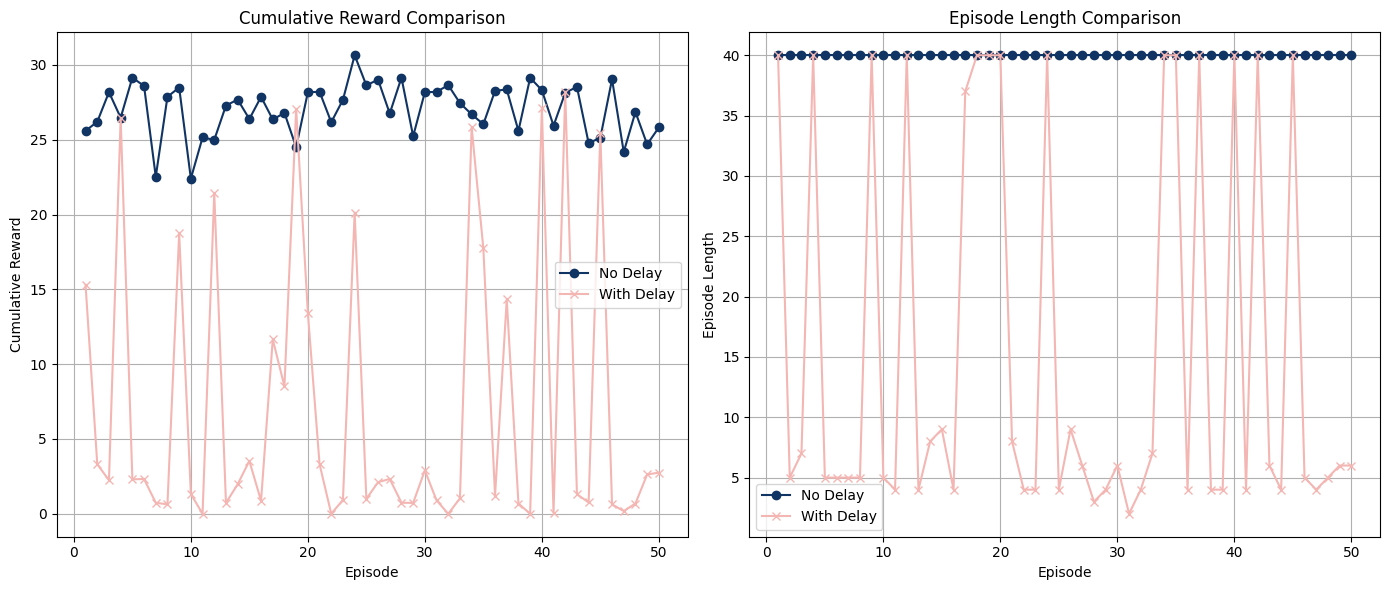

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of test episodes
n_episodes = 50

# Exponential delay parameters
scale = 1.2  # Mean delay
max_delay = 2  # Maximum delay in seconds

# Tracking performance metrics for both tests
cumulative_rewards_no_delay = []
cumulative_rewards_with_delay = []
episode_lengths_no_delay = []
episode_lengths_with_delay = []
crashes_no_delay = 0
crashes_with_delay = 0

# Run testing without delay
for episode in range(n_episodes):
    obs, info = env.reset()
    total_reward = 0
    done = False
    episode_length = 0
    episode_crash = False  # Track crash per episode

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        episode_length += 1
        done = terminated or truncated

        # Check if a crash occurred
        if info.get("crashed", False):
            episode_crash = True

    cumulative_rewards_no_delay.append(total_reward)
    episode_lengths_no_delay.append(episode_length)
    crashes_no_delay += int(episode_crash)

    print(f"Episode {episode + 1} (No Delay): Total Reward = {total_reward:.2f}, Length = {episode_length} timesteps, Crash: {episode_crash}")

# Run testing with delay
for episode in range(n_episodes):
    obs, info = env.reset()
    total_reward = 0
    done = False
    episode_length = 0
    episode_crash = False

    # Generate a random delay from an exponential distribution, capped at max_delay
    random_delay = min(np.random.exponential(scale), max_delay)

    while not done:
        action, _ = model.predict(obs, deterministic=True)

        # Apply the computation delay before executing the action
        env.unwrapped.elapse(random_delay)

        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        episode_length += 1
        done = terminated or truncated

        # Check if a crash occurred
        if info.get("crashed", False):
            episode_crash = True

    cumulative_rewards_with_delay.append(total_reward)
    episode_lengths_with_delay.append(episode_length)
    crashes_with_delay += int(episode_crash)

    print(f"Episode {episode + 1} (With Delay): Delay = {random_delay:.2f}s, Total Reward = {total_reward:.2f}, Length = {episode_length} timesteps, Crash: {episode_crash}")

env.close()

# Compute statistics
mean_reward_no_delay = sum(cumulative_rewards_no_delay) / n_episodes
mean_reward_with_delay = sum(cumulative_rewards_with_delay) / n_episodes
mean_episode_length_no_delay = sum(episode_lengths_no_delay) / n_episodes
mean_episode_length_with_delay = sum(episode_lengths_with_delay) / n_episodes
crash_rate_no_delay = crashes_no_delay / n_episodes
crash_rate_with_delay = crashes_with_delay / n_episodes

print(f"\nWithout Delay - Mean Reward: {mean_reward_no_delay:.2f}, Mean Episode Length: {mean_episode_length_no_delay:.2f}, Crash Rate: {crash_rate_no_delay:.2%}")
print(f"With Delay - Mean Reward: {mean_reward_with_delay:.2f}, Mean Episode Length: {mean_episode_length_with_delay:.2f}, Crash Rate: {crash_rate_with_delay:.2%}")

# Plot the results
episodes = range(1, n_episodes + 1)

plt.figure(figsize=(14, 6))

# Cumulative Reward Comparison
plt.subplot(1, 2, 1)
plt.plot(episodes, cumulative_rewards_no_delay, marker='o', label="No Delay", color='#103463')
plt.plot(episodes, cumulative_rewards_with_delay, marker='x', label="With Delay", color='#f3b6b3')
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward Comparison")
plt.legend()
plt.grid(True)

# Episode Length Comparison
plt.subplot(1, 2, 2)
plt.plot(episodes, episode_lengths_no_delay, marker='o', label="No Delay", color='#103463')
plt.plot(episodes, episode_lengths_with_delay, marker='x', label="With Delay", color='#f3b6b3')
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.title("Episode Length Comparison")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


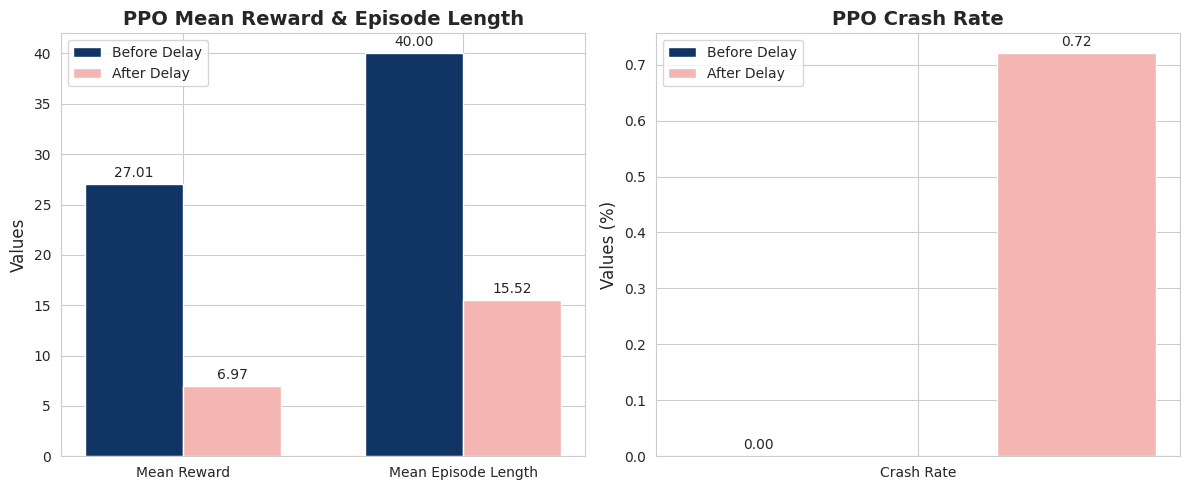

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define metrics
metrics_main = ["Mean Reward", "Mean Episode Length"]
before_delay_main = [mean_reward_no_delay, mean_episode_length_no_delay]  # Mean Reward, Episode Length (before delay)
after_delay_main = [mean_reward_with_delay, mean_episode_length_with_delay]  # Mean Reward, Episode Length (after delay)

metrics_crash = ["Crash Rate"]
before_delay_crash = [crash_rate_no_delay]  # Crash Rate (before delay)
after_delay_crash = [crash_rate_with_delay]  # Crash Rate (after delay)

# Set Seaborn style
sns.set_style("whitegrid")

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- First Chart: Mean Reward & Episode Length ---
x = np.arange(len(metrics_main))  # Label positions
width = 0.35  # Bar width

bars1 = axes[0].bar(x - width/2, before_delay_main, width, label="Before Delay", color="#103463")
bars2 = axes[0].bar(x + width/2, after_delay_main, width, label="After Delay", color="#f3b6b3")

# Labels & Title
axes[0].set_title("PPO Mean Reward & Episode Length", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Values", fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_main)
axes[0].legend()

# Show value labels on bars
def add_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1, axes[0])
add_labels(bars2, axes[0])

# --- Second Chart: Crash Rate ---
x_crash = np.arange(len(metrics_crash))  # Label positions
crash_width = 0.3  # Narrower bar width for crash rate

bars3 = axes[1].bar(x_crash - crash_width, before_delay_crash, crash_width, label="Before Delay", color="#103463")
bars4 = axes[1].bar(x_crash + crash_width, after_delay_crash, crash_width, label="After Delay", color="#f3b6b3")

# Labels & Title
axes[1].set_title("PPO Crash Rate", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Values (%)", fontsize=12)
axes[1].set_xticks(x_crash)
axes[1].set_xticklabels(metrics_crash)
axes[1].legend()

# Show value labels on bars
add_labels(bars3, axes[1])
add_labels(bars4, axes[1])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Episode 1: Delay = 0.50s, Total Reward = 26.40, Length = 40 timesteps
Episode 2: Delay = 0.88s, Total Reward = 19.10, Length = 40 timesteps
Episode 3: Delay = 0.33s, Total Reward = 27.21, Length = 40 timesteps
Episode 4: Delay = 2.00s, Total Reward = 0.69, Length = 27 timesteps
Episode 5: Delay = 0.08s, Total Reward = 26.40, Length = 40 timesteps
Episode 6: Delay = 0.02s, Total Reward = 28.77, Length = 40 timesteps
Episode 7: Delay = 1.79s, Total Reward = 0.27, Length = 1 timesteps
Episode 8: Delay = 2.00s, Total Reward = 8.09, Length = 40 timesteps
Episode 9: Delay = 2.00s, Total Reward = 5.25, Length = 25 timesteps
Episode 10: Delay = 1.23s, Total Reward = 9.27, Length = 40 timesteps
Episode 11: Delay = 1.30s, Total Reward = 8.54, Length = 34 timesteps
Episode 12: Delay = 0.23s, Total Reward = 29.16, Length = 40 timesteps
Episode 13: Delay = 1.14s, Total Reward = 8.33, Length = 40 timesteps
Episode 14: Delay = 0.21s, Total Reward = 26.13, Length = 40 timesteps
Episode 15: Delay = 0.3

/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = utils.lmap(df[feature], [f_range[0], f_range[1]], [-1, 1])
/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = np.clip(df[feature], -1, 1)
/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set 

Episode 23: Delay = 0.09s, Total Reward = 28.76, Length = 40 timesteps
Episode 24: Delay = 0.50s, Total Reward = 22.79, Length = 40 timesteps
Episode 25: Delay = 0.70s, Total Reward = 18.96, Length = 40 timesteps
Episode 26: Delay = 1.75s, Total Reward = 4.28, Length = 23 timesteps
Episode 27: Delay = 0.85s, Total Reward = 19.66, Length = 40 timesteps
Episode 28: Delay = 0.43s, Total Reward = 29.01, Length = 40 timesteps
Episode 29: Delay = 1.14s, Total Reward = 15.21, Length = 40 timesteps
Episode 30: Delay = 1.78s, Total Reward = 3.14, Length = 19 timesteps
Episode 31: Delay = 2.00s, Total Reward = 1.37, Length = 9 timesteps
Episode 32: Delay = 1.45s, Total Reward = 7.35, Length = 40 timesteps
Episode 33: Delay = 0.47s, Total Reward = 25.44, Length = 40 timesteps
Episode 34: Delay = 0.06s, Total Reward = 24.96, Length = 40 timesteps
Episode 35: Delay = 1.16s, Total Reward = 7.48, Length = 11 timesteps
Episode 36: Delay = 2.00s, Total Reward = 4.71, Length = 18 timesteps
Episode 37: D

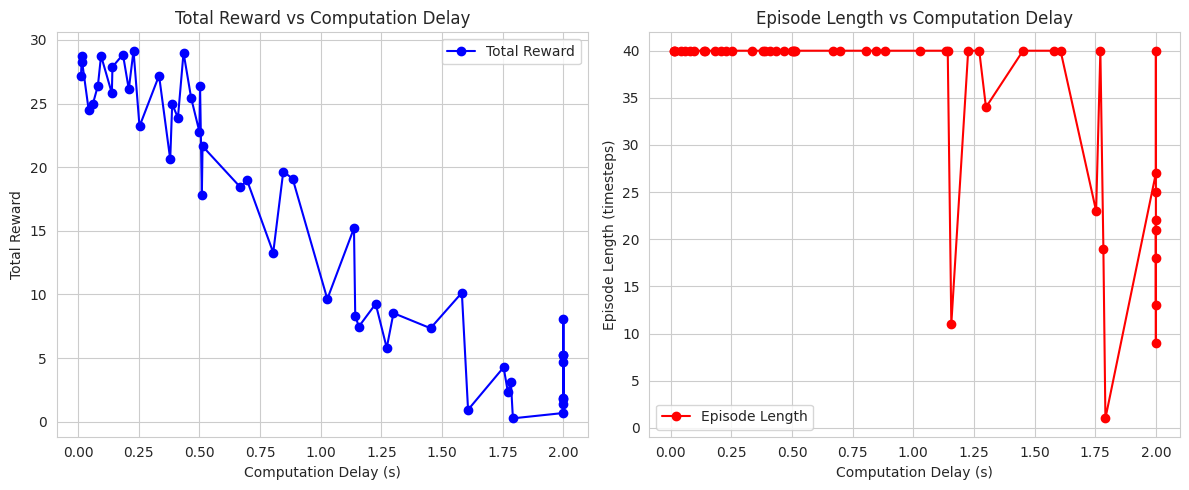

In [ ]:
import matplotlib.pyplot as plt

def evaluate_with_exponential_computation_costs(scale, max_delay, n_eval_episodes=50):
    results = []

    for episode in range(n_eval_episodes):

        # Generate a random delay using exponential distribution, capped at max_delay (2s)
        random_delay = min(np.random.exponential(scale), max_delay)

        obs, info = env.reset()

        # Run one episode
        total_reward = 0
        episode_length = 0
        done = False

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            env.unwrapped.elapse(random_delay, reset_steering=True)
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            episode_length += 1
            done = terminated or truncated

        # Store results
        results.append({
            'episode': episode + 1,
            'computation_delay': random_delay,
            'total_reward': total_reward,
            'episode_length': episode_length
        })

        # Print episode results
        print(f"Episode {episode + 1}: Delay = {random_delay:.2f}s, "
              f"Total Reward = {total_reward:.2f}, Length = {episode_length} timesteps")

        # Close the environment
        env.close()

    return results


# Set parameters for exponential sampling
scale = 1.2  # Mean delay (adjustable)
max_delay = 2  # Maximum delay capped at 2 seconds

# Path to the pre-trained model

# Run the evaluations
results = evaluate_with_exponential_computation_costs(scale, max_delay, n_eval_episodes=50)

# Compute mean values
mean_reward = np.mean([r['total_reward'] for r in results])
mean_length = np.mean([r['episode_length'] for r in results])

print(f"\nMean Total Reward: {mean_reward:.2f}")
print(f"Mean Episode Length: {mean_length:.2f} timesteps")



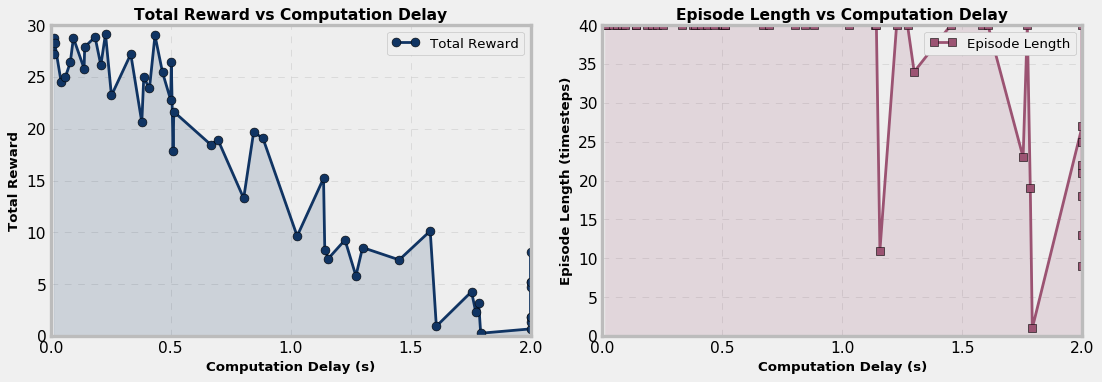

In [ ]:

def plot_results_pretty(results):
    # Sort results by computation delay
    results = sorted(results, key=lambda x: x['computation_delay'])

    delays = [r['computation_delay'] for r in results]
    rewards = [r['total_reward'] for r in results]
    lengths = [r['episode_length'] for r in results]

    # Set style
    plt.style.use("tableau-colorblind10")  # Prettier theme

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Color settings
    reward_color = "#103463"   # Coral red
    length_color = "#9b5372"   # Teal green

    # Plot Total Reward vs Delay
    axes[0].plot(delays, rewards, marker='o', markersize=8, linestyle='-', linewidth=2.5, color=reward_color, label='Total Reward')
    axes[0].fill_between(delays, rewards, color=reward_color, alpha=0.15)  # Light shading for effect
    axes[0].set_xlabel('Computation Delay (s)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Total Reward', fontsize=12, fontweight='bold')
    axes[0].set_title('Total Reward vs Computation Delay', fontsize=14, fontweight='bold')
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].legend(fontsize=12)

    # Plot Episode Length vs Delay
    axes[1].plot(delays, lengths, marker='s', markersize=8, linestyle='-', linewidth=2.5, color=length_color, label='Episode Length')
    axes[1].fill_between(delays, lengths, color=length_color, alpha=0.15)
    axes[1].set_xlabel('Computation Delay (s)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Episode Length (timesteps)', fontsize=12, fontweight='bold')
    axes[1].set_title('Episode Length vs Computation Delay', fontsize=14, fontweight='bold')
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].legend(fontsize=12)

    plt.tight_layout()
    plt.show()

plot_results_pretty(results)


In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']